In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import evaluate

In [4]:
# loading the data
df_train = pd.read_csv("/content/train.csv")
df_val = pd.read_csv('/content/val.csv')

In [5]:
df_train

,change,paragraph1,paragraph2
0,1,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...
2,1,For those who have questions regarding any med...,There is literally no quicker way to guarantee...
3,0,There is literally no quicker way to guarantee...,"Granted, but he's a former football player. Th..."
4,1,"Granted, but he's a former football player. Th...",As usual they will try to elevate the black re...
...,...,...,...
21900,1,The Supreme Court is just waiting to throw awa...,"In general, be courteous to others. Debate/dis..."
21901,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...
21902,1,For those who have questions regarding any med...,We have a illegitimate Supreme Court and Biden...
21903,0,We have a illegitimate Supreme Court and Biden...,It had none since the day the overturning of R...


In [6]:
# creating a raw_datasets dict to store datapoints for 'train' and 'validation' seperately
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(df_train[['paragraph1', 'paragraph2', 'change']]),
    'validation': Dataset.from_pandas(df_val[['paragraph1', 'paragraph2', 'change']])
})

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['paragraph1', 'paragraph2', 'change'],
        num_rows: 21905
    })
    validation: Dataset({
        features: ['paragraph1', 'paragraph2', 'change'],
        num_rows: 4592
    })
})

In [8]:
# initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# defining the tokenizer function that will tokenize
# each paragraph padding it to max length = 512
def tokenize(example):
    return tokenizer(example['paragraph1'], example['paragraph2'], truncation = True, padding = 'max_length', max_length = 512)

# tokenizing the datasets
tokenized_datasets = raw_datasets.map(tokenize, batched = True)

# removing the output that is made of strings as we do not need it
tokenized_datasets = tokenized_datasets.remove_columns(['paragraph1', 'paragraph2'])

# renaming 'change' column to 'labels' to match the expected input format for the BERT model
tokenized_datasets = tokenized_datasets.rename_column('change', 'labels')

# setting the format as PyTorch tensors
tokenized_datasets.set_format('torch')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/21905 [00:00<?, ? examples/s]

Map:   0%|          | 0/4592 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21905
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4592
    })
})

In [10]:
# initializing the DataCollator
collator = DataCollatorWithPadding(tokenizer = tokenizer)

# creating a DataLoader both for training and evaluation
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle = True, batch_size = 8, collate_fn = collator, num_workers = 4)
eval_dataloader = DataLoader(tokenized_datasets['validation'], batch_size = 8, collate_fn = collator, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# loading the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 2)

# initializing the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# learning rate scheduler set to 5 epochs
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps,)

print(num_training_steps)

13695


cuda


  0%|          | 0/13695 [00:00<?, ?it/s]

Starting epoch 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 1/13695 [00:02<8:36:37,  2.26s/it]

Epoch 1 | Step 0 | Loss: 0.6002197265625


  0%|          | 52/13695 [00:12<46:59,  4.84it/s]

Epoch 1 | Step 50 | Loss: 0.5753746032714844


  1%|          | 101/13695 [00:24<59:15,  3.82it/s]  

Epoch 1 | Step 100 | Loss: 0.5177268981933594


  1%|          | 151/13695 [00:35<48:06,  4.69it/s]

Epoch 1 | Step 150 | Loss: 0.5842971801757812


  1%|▏         | 202/13695 [00:48<47:33,  4.73it/s]

Epoch 1 | Step 200 | Loss: 0.7007699012756348


  2%|▏         | 251/13695 [00:58<48:36,  4.61it/s]

Epoch 1 | Step 250 | Loss: 0.44093191623687744


  2%|▏         | 302/13695 [01:09<47:58,  4.65it/s]

Epoch 1 | Step 300 | Loss: 0.30807995796203613


  3%|▎         | 351/13695 [01:20<48:22,  4.60it/s]

Epoch 1 | Step 350 | Loss: 0.6207175254821777


  3%|▎         | 401/13695 [01:31<49:59,  4.43it/s]

Epoch 1 | Step 400 | Loss: 0.45172905921936035


  3%|▎         | 451/13695 [01:42<49:30,  4.46it/s]

Epoch 1 | Step 450 | Loss: 0.3355015516281128


  4%|▎         | 502/13695 [01:54<48:25,  4.54it/s]

Epoch 1 | Step 500 | Loss: 0.4845256805419922


  4%|▍         | 551/13695 [02:05<48:45,  4.49it/s]

Epoch 1 | Step 550 | Loss: 0.21734973788261414


  4%|▍         | 602/13695 [02:16<47:40,  4.58it/s]

Epoch 1 | Step 600 | Loss: 0.5424443483352661


  5%|▍         | 652/13695 [02:27<47:36,  4.57it/s]

Epoch 1 | Step 650 | Loss: 0.5898990631103516


  5%|▌         | 701/13695 [02:38<48:22,  4.48it/s]

Epoch 1 | Step 700 | Loss: 0.60528564453125


  5%|▌         | 751/13695 [02:49<48:12,  4.48it/s]

Epoch 1 | Step 750 | Loss: 0.6997432708740234


  6%|▌         | 802/13695 [03:01<46:52,  4.58it/s]

Epoch 1 | Step 800 | Loss: 0.18065392971038818


  6%|▌         | 851/13695 [03:12<47:36,  4.50it/s]

Epoch 1 | Step 850 | Loss: 0.2814995050430298


  7%|▋         | 902/13695 [03:23<46:47,  4.56it/s]

Epoch 1 | Step 900 | Loss: 0.51912522315979


  7%|▋         | 951/13695 [03:34<46:30,  4.57it/s]

Epoch 1 | Step 950 | Loss: 0.43867528438568115


  7%|▋         | 1001/13695 [03:45<47:01,  4.50it/s]

Epoch 1 | Step 1000 | Loss: 0.4328289031982422


  8%|▊         | 1051/13695 [03:56<46:28,  4.53it/s]

Epoch 1 | Step 1050 | Loss: 0.3442649245262146


  8%|▊         | 1102/13695 [04:07<45:51,  4.58it/s]

Epoch 1 | Step 1100 | Loss: 0.33012962341308594


  8%|▊         | 1151/13695 [04:18<45:51,  4.56it/s]

Epoch 1 | Step 1150 | Loss: 0.43163183331489563


  9%|▉         | 1202/13695 [04:29<45:36,  4.57it/s]

Epoch 1 | Step 1200 | Loss: 0.4807923138141632


  9%|▉         | 1252/13695 [04:40<45:35,  4.55it/s]

Epoch 1 | Step 1250 | Loss: 0.22800028324127197


  9%|▉         | 1301/13695 [04:51<46:15,  4.47it/s]

Epoch 1 | Step 1300 | Loss: 0.8680962324142456


 10%|▉         | 1351/13695 [05:02<45:01,  4.57it/s]

Epoch 1 | Step 1350 | Loss: 0.19028709828853607


 10%|█         | 1401/13695 [05:13<44:48,  4.57it/s]

Epoch 1 | Step 1400 | Loss: 0.17071658372879028


 11%|█         | 1451/13695 [05:24<45:50,  4.45it/s]

Epoch 1 | Step 1450 | Loss: 0.3975238800048828


 11%|█         | 1501/13695 [05:35<44:35,  4.56it/s]

Epoch 1 | Step 1500 | Loss: 0.3586804270744324


 11%|█▏        | 1551/13695 [05:46<44:49,  4.52it/s]

Epoch 1 | Step 1550 | Loss: 0.5297596454620361


 12%|█▏        | 1601/13695 [05:57<44:35,  4.52it/s]

Epoch 1 | Step 1600 | Loss: 0.15900468826293945


 12%|█▏        | 1651/13695 [06:08<44:43,  4.49it/s]

Epoch 1 | Step 1650 | Loss: 0.24700413644313812


 12%|█▏        | 1701/13695 [06:19<43:28,  4.60it/s]

Epoch 1 | Step 1700 | Loss: 0.5320563316345215


 13%|█▎        | 1751/13695 [06:30<43:40,  4.56it/s]

Epoch 1 | Step 1750 | Loss: 0.5005885362625122


 13%|█▎        | 1801/13695 [06:41<43:50,  4.52it/s]

Epoch 1 | Step 1800 | Loss: 0.4379854202270508


 14%|█▎        | 1851/13695 [06:52<43:46,  4.51it/s]

Epoch 1 | Step 1850 | Loss: 0.3079543113708496


 14%|█▍        | 1901/13695 [07:03<43:15,  4.54it/s]

Epoch 1 | Step 1900 | Loss: 0.5892181396484375


 14%|█▍        | 1951/13695 [07:14<42:49,  4.57it/s]

Epoch 1 | Step 1950 | Loss: 0.4557405114173889


 15%|█▍        | 2001/13695 [07:25<43:22,  4.49it/s]

Epoch 1 | Step 2000 | Loss: 0.47952908277511597


 15%|█▍        | 2052/13695 [07:37<42:30,  4.56it/s]

Epoch 1 | Step 2050 | Loss: 0.27520185708999634


 15%|█▌        | 2102/13695 [07:48<42:24,  4.56it/s]

Epoch 1 | Step 2100 | Loss: 0.4801487922668457


 16%|█▌        | 2151/13695 [07:59<43:08,  4.46it/s]

Epoch 1 | Step 2150 | Loss: 0.5086078643798828


 16%|█▌        | 2201/13695 [08:09<41:56,  4.57it/s]

Epoch 1 | Step 2200 | Loss: 0.5261852741241455


 16%|█▋        | 2252/13695 [08:21<41:56,  4.55it/s]

Epoch 1 | Step 2250 | Loss: 0.28104424476623535


 17%|█▋        | 2301/13695 [08:32<41:32,  4.57it/s]

Epoch 1 | Step 2300 | Loss: 0.225267231464386


 17%|█▋        | 2351/13695 [08:42<41:38,  4.54it/s]

Epoch 1 | Step 2350 | Loss: 0.19573193788528442


 18%|█▊        | 2401/13695 [08:53<41:19,  4.55it/s]

Epoch 1 | Step 2400 | Loss: 0.7261508703231812


 18%|█▊        | 2451/13695 [09:05<41:25,  4.52it/s]

Epoch 1 | Step 2450 | Loss: 0.5468747615814209


 18%|█▊        | 2501/13695 [09:16<41:43,  4.47it/s]

Epoch 1 | Step 2500 | Loss: 0.6083686351776123


 19%|█▊        | 2551/13695 [09:27<41:05,  4.52it/s]

Epoch 1 | Step 2550 | Loss: 0.4311257004737854


 19%|█▉        | 2602/13695 [09:38<40:11,  4.60it/s]

Epoch 1 | Step 2600 | Loss: 0.6516612768173218


 19%|█▉        | 2651/13695 [09:49<40:15,  4.57it/s]

Epoch 1 | Step 2650 | Loss: 0.4271102249622345


 20%|█▉        | 2701/13695 [10:00<40:51,  4.48it/s]

Epoch 1 | Step 2700 | Loss: 0.30480754375457764


 20%|██        | 2739/13695 [10:08<36:26,  5.01it/s]

Epoch 1 | Average loss: 0.4291


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 | Train F1: 0.7992 | Val F1: 0.8288
Starting epoch 2/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 20%|██        | 2741/13695 [12:29<90:25:56, 29.72s/it] 

Epoch 2 | Step 0 | Loss: 0.35415005683898926


 20%|██        | 2790/13695 [12:40<39:57,  4.55it/s]

Epoch 2 | Step 50 | Loss: 0.4821012020111084


 21%|██        | 2841/13695 [12:51<39:22,  4.59it/s]

Epoch 2 | Step 100 | Loss: 0.27759861946105957


 21%|██        | 2891/13695 [13:02<39:22,  4.57it/s]

Epoch 2 | Step 150 | Loss: 0.3957210183143616


 21%|██▏       | 2940/13695 [13:13<40:06,  4.47it/s]

Epoch 2 | Step 200 | Loss: 0.22883518040180206


 22%|██▏       | 2990/13695 [13:24<39:02,  4.57it/s]

Epoch 2 | Step 250 | Loss: 0.2982012629508972


 22%|██▏       | 3040/13695 [13:35<39:21,  4.51it/s]

Epoch 2 | Step 300 | Loss: 0.4157203435897827


 23%|██▎       | 3090/13695 [13:46<39:21,  4.49it/s]

Epoch 2 | Step 350 | Loss: 0.27673864364624023


 23%|██▎       | 3140/13695 [13:57<39:23,  4.47it/s]

Epoch 2 | Step 400 | Loss: 0.17266583442687988


 23%|██▎       | 3191/13695 [14:08<38:28,  4.55it/s]

Epoch 2 | Step 450 | Loss: 0.28448182344436646


 24%|██▎       | 3240/13695 [14:19<38:28,  4.53it/s]

Epoch 2 | Step 500 | Loss: 0.24202626943588257


 24%|██▍       | 3290/13695 [14:30<38:34,  4.50it/s]

Epoch 2 | Step 550 | Loss: 0.3219386637210846


 24%|██▍       | 3341/13695 [14:41<37:41,  4.58it/s]

Epoch 2 | Step 600 | Loss: 0.49494174122810364


 25%|██▍       | 3391/13695 [14:52<37:40,  4.56it/s]

Epoch 2 | Step 650 | Loss: 0.28877365589141846


 25%|██▌       | 3440/13695 [15:03<38:10,  4.48it/s]

Epoch 2 | Step 700 | Loss: 0.4869806170463562


 25%|██▌       | 3490/13695 [15:14<37:27,  4.54it/s]

Epoch 2 | Step 750 | Loss: 0.2926690876483917


 26%|██▌       | 3540/13695 [15:25<37:50,  4.47it/s]

Epoch 2 | Step 800 | Loss: 0.5075615048408508


 26%|██▌       | 3590/13695 [15:36<37:05,  4.54it/s]

Epoch 2 | Step 850 | Loss: 0.48858642578125


 27%|██▋       | 3640/13695 [15:47<36:55,  4.54it/s]

Epoch 2 | Step 900 | Loss: 0.3752106726169586


 27%|██▋       | 3690/13695 [15:58<36:41,  4.54it/s]

Epoch 2 | Step 950 | Loss: 0.20199094712734222


 27%|██▋       | 3740/13695 [16:09<36:27,  4.55it/s]

Epoch 2 | Step 1000 | Loss: 0.4784735143184662


 28%|██▊       | 3790/13695 [16:20<36:53,  4.48it/s]

Epoch 2 | Step 1050 | Loss: 0.3773772418498993


 28%|██▊       | 3841/13695 [16:32<35:46,  4.59it/s]

Epoch 2 | Step 1100 | Loss: 0.1037481427192688


 28%|██▊       | 3890/13695 [16:42<35:56,  4.55it/s]

Epoch 2 | Step 1150 | Loss: 0.4557790756225586


 29%|██▉       | 3940/13695 [16:54<36:23,  4.47it/s]

Epoch 2 | Step 1200 | Loss: 0.38434886932373047


 29%|██▉       | 3990/13695 [17:04<35:50,  4.51it/s]

Epoch 2 | Step 1250 | Loss: 0.2170933187007904


 29%|██▉       | 4040/13695 [17:15<35:20,  4.55it/s]

Epoch 2 | Step 1300 | Loss: 0.2606552243232727


 30%|██▉       | 4091/13695 [17:27<35:02,  4.57it/s]

Epoch 2 | Step 1350 | Loss: 0.10225802659988403


 30%|███       | 4140/13695 [17:38<35:29,  4.49it/s]

Epoch 2 | Step 1400 | Loss: 0.19567176699638367


 31%|███       | 4191/13695 [17:49<34:48,  4.55it/s]

Epoch 2 | Step 1450 | Loss: 0.9595057368278503


 31%|███       | 4240/13695 [18:00<34:51,  4.52it/s]

Epoch 2 | Step 1500 | Loss: 0.5022457242012024


 31%|███▏      | 4290/13695 [18:11<34:54,  4.49it/s]

Epoch 2 | Step 1550 | Loss: 0.37688499689102173


 32%|███▏      | 4340/13695 [18:22<34:32,  4.51it/s]

Epoch 2 | Step 1600 | Loss: 0.20252782106399536


 32%|███▏      | 4390/13695 [18:33<33:55,  4.57it/s]

Epoch 2 | Step 1650 | Loss: 0.26954251527786255


 32%|███▏      | 4440/13695 [18:44<33:40,  4.58it/s]

Epoch 2 | Step 1700 | Loss: 0.7859275341033936


 33%|███▎      | 4490/13695 [18:55<34:12,  4.48it/s]

Epoch 2 | Step 1750 | Loss: 0.4147726595401764


 33%|███▎      | 4541/13695 [19:06<33:22,  4.57it/s]

Epoch 2 | Step 1800 | Loss: 0.02755904197692871


 34%|███▎      | 4590/13695 [19:17<33:12,  4.57it/s]

Epoch 2 | Step 1850 | Loss: 0.29208043217658997


 34%|███▍      | 4640/13695 [19:28<33:17,  4.53it/s]

Epoch 2 | Step 1900 | Loss: 0.3116852939128876


 34%|███▍      | 4690/13695 [19:39<32:49,  4.57it/s]

Epoch 2 | Step 1950 | Loss: 0.5961710810661316


 35%|███▍      | 4741/13695 [19:50<32:35,  4.58it/s]

Epoch 2 | Step 2000 | Loss: 0.6462898254394531


 35%|███▍      | 4790/13695 [20:01<33:55,  4.38it/s]

Epoch 2 | Step 2050 | Loss: 0.4309180974960327


 35%|███▌      | 4840/13695 [20:12<32:22,  4.56it/s]

Epoch 2 | Step 2100 | Loss: 0.1737518310546875


 36%|███▌      | 4891/13695 [20:23<31:58,  4.59it/s]

Epoch 2 | Step 2150 | Loss: 0.12253542244434357


 36%|███▌      | 4940/13695 [20:34<33:30,  4.36it/s]

Epoch 2 | Step 2200 | Loss: 0.32245421409606934


 36%|███▋      | 4990/13695 [20:45<31:52,  4.55it/s]

Epoch 2 | Step 2250 | Loss: 0.2863253653049469


 37%|███▋      | 5041/13695 [20:56<31:37,  4.56it/s]

Epoch 2 | Step 2300 | Loss: 0.23546554148197174


 37%|███▋      | 5090/13695 [21:07<31:45,  4.52it/s]

Epoch 2 | Step 2350 | Loss: 0.036344125866889954


 38%|███▊      | 5140/13695 [21:18<31:46,  4.49it/s]

Epoch 2 | Step 2400 | Loss: 0.30112141370773315


 38%|███▊      | 5191/13695 [21:29<31:02,  4.57it/s]

Epoch 2 | Step 2450 | Loss: 0.3691633343696594


 38%|███▊      | 5240/13695 [21:40<31:08,  4.52it/s]

Epoch 2 | Step 2500 | Loss: 0.10990302264690399


 39%|███▊      | 5290/13695 [21:51<30:57,  4.52it/s]

Epoch 2 | Step 2550 | Loss: 0.3090806305408478


 39%|███▉      | 5340/13695 [22:02<30:25,  4.58it/s]

Epoch 2 | Step 2600 | Loss: 0.41086041927337646


 39%|███▉      | 5391/13695 [22:13<30:22,  4.56it/s]

Epoch 2 | Step 2650 | Loss: 0.12045502662658691


 40%|███▉      | 5441/13695 [22:24<30:16,  4.54it/s]

Epoch 2 | Step 2700 | Loss: 0.13464486598968506


 40%|███▉      | 5477/13695 [22:32<30:05,  4.55it/s]

Epoch 2 | Average loss: 0.3226


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2 | Train F1: 0.8680 | Val F1: 0.8558
Starting epoch 3/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 40%|████      | 5480/13695 [24:53<56:04:20, 24.57s/it]

Epoch 3 | Step 0 | Loss: 0.27808302640914917


 40%|████      | 5529/13695 [25:04<30:10,  4.51it/s]

Epoch 3 | Step 50 | Loss: 0.05698506534099579


 41%|████      | 5580/13695 [25:15<29:34,  4.57it/s]

Epoch 3 | Step 100 | Loss: 0.2268296629190445


 41%|████      | 5629/13695 [25:26<29:35,  4.54it/s]

Epoch 3 | Step 150 | Loss: 0.09520077705383301


 41%|████▏     | 5679/13695 [25:37<29:00,  4.61it/s]

Epoch 3 | Step 200 | Loss: 0.023305639624595642


 42%|████▏     | 5729/13695 [25:48<29:22,  4.52it/s]

Epoch 3 | Step 250 | Loss: 0.4350769519805908


 42%|████▏     | 5779/13695 [25:59<29:00,  4.55it/s]

Epoch 3 | Step 300 | Loss: 0.17460259795188904


 43%|████▎     | 5830/13695 [26:10<28:34,  4.59it/s]

Epoch 3 | Step 350 | Loss: 0.07253505289554596


 43%|████▎     | 5879/13695 [26:21<28:55,  4.50it/s]

Epoch 3 | Step 400 | Loss: 0.5599687099456787


 43%|████▎     | 5929/13695 [26:32<28:11,  4.59it/s]

Epoch 3 | Step 450 | Loss: 0.012285783886909485


 44%|████▎     | 5980/13695 [26:43<28:05,  4.58it/s]

Epoch 3 | Step 500 | Loss: 0.10098192095756531


 44%|████▍     | 6029/13695 [26:54<28:05,  4.55it/s]

Epoch 3 | Step 550 | Loss: 0.01696377992630005


 44%|████▍     | 6079/13695 [27:05<27:52,  4.55it/s]

Epoch 3 | Step 600 | Loss: 0.2655350863933563


 45%|████▍     | 6129/13695 [27:16<27:35,  4.57it/s]

Epoch 3 | Step 650 | Loss: 0.05983521044254303


 45%|████▌     | 6179/13695 [27:27<27:54,  4.49it/s]

Epoch 3 | Step 700 | Loss: 0.1240725964307785


 45%|████▌     | 6229/13695 [27:38<27:28,  4.53it/s]

Epoch 3 | Step 750 | Loss: 0.04427088797092438


 46%|████▌     | 6280/13695 [27:50<27:05,  4.56it/s]

Epoch 3 | Step 800 | Loss: 0.13600581884384155


 46%|████▌     | 6329/13695 [28:00<26:57,  4.55it/s]

Epoch 3 | Step 850 | Loss: 0.007576927542686462


 47%|████▋     | 6379/13695 [28:11<27:05,  4.50it/s]

Epoch 3 | Step 900 | Loss: 0.13054609298706055


 47%|████▋     | 6429/13695 [28:22<26:33,  4.56it/s]

Epoch 3 | Step 950 | Loss: 0.04356171190738678


 47%|████▋     | 6479/13695 [28:33<27:00,  4.45it/s]

Epoch 3 | Step 1000 | Loss: 0.22671020030975342


 48%|████▊     | 6529/13695 [28:44<26:25,  4.52it/s]

Epoch 3 | Step 1050 | Loss: 0.09269492328166962


 48%|████▊     | 6579/13695 [28:55<26:18,  4.51it/s]

Epoch 3 | Step 1100 | Loss: 0.04995162785053253


 48%|████▊     | 6629/13695 [29:06<25:45,  4.57it/s]

Epoch 3 | Step 1150 | Loss: 0.10433067381381989


 49%|████▉     | 6679/13695 [29:17<25:30,  4.58it/s]

Epoch 3 | Step 1200 | Loss: 0.04544569551944733


 49%|████▉     | 6729/13695 [29:29<25:37,  4.53it/s]

Epoch 3 | Step 1250 | Loss: 0.25170373916625977


 50%|████▉     | 6780/13695 [29:40<25:05,  4.59it/s]

Epoch 3 | Step 1300 | Loss: 0.0601944774389267


 50%|████▉     | 6830/13695 [29:51<24:56,  4.59it/s]

Epoch 3 | Step 1350 | Loss: 0.09503903985023499


 50%|█████     | 6879/13695 [30:02<24:56,  4.55it/s]

Epoch 3 | Step 1400 | Loss: 0.041014403104782104


 51%|█████     | 6929/13695 [30:13<25:14,  4.47it/s]

Epoch 3 | Step 1450 | Loss: 0.1274242401123047


 51%|█████     | 6980/13695 [30:24<24:20,  4.60it/s]

Epoch 3 | Step 1500 | Loss: 0.05500544607639313


 51%|█████▏    | 7029/13695 [30:35<24:13,  4.58it/s]

Epoch 3 | Step 1550 | Loss: 0.06575430929660797


 52%|█████▏    | 7079/13695 [30:46<24:29,  4.50it/s]

Epoch 3 | Step 1600 | Loss: 0.4412567913532257


 52%|█████▏    | 7130/13695 [30:57<23:50,  4.59it/s]

Epoch 3 | Step 1650 | Loss: 0.031645268201828


 52%|█████▏    | 7180/13695 [31:08<23:45,  4.57it/s]

Epoch 3 | Step 1700 | Loss: 0.00953298807144165


 53%|█████▎    | 7229/13695 [31:19<24:00,  4.49it/s]

Epoch 3 | Step 1750 | Loss: 0.23565080761909485


 53%|█████▎    | 7279/13695 [31:30<23:48,  4.49it/s]

Epoch 3 | Step 1800 | Loss: 0.09038187563419342


 54%|█████▎    | 7329/13695 [31:41<23:11,  4.58it/s]

Epoch 3 | Step 1850 | Loss: 0.09459812939167023


 54%|█████▍    | 7380/13695 [31:52<23:00,  4.57it/s]

Epoch 3 | Step 1900 | Loss: 0.008839026093482971


 54%|█████▍    | 7429/13695 [32:03<23:15,  4.49it/s]

Epoch 3 | Step 1950 | Loss: 0.3240390419960022


 55%|█████▍    | 7480/13695 [32:14<22:41,  4.56it/s]

Epoch 3 | Step 2000 | Loss: 0.11570912599563599


 55%|█████▍    | 7530/13695 [32:25<22:23,  4.59it/s]

Epoch 3 | Step 2050 | Loss: 0.021404489874839783


 55%|█████▌    | 7579/13695 [32:36<22:32,  4.52it/s]

Epoch 3 | Step 2100 | Loss: 0.0915641188621521


 56%|█████▌    | 7629/13695 [32:47<21:57,  4.60it/s]

Epoch 3 | Step 2150 | Loss: 0.0007346570491790771


 56%|█████▌    | 7679/13695 [32:58<22:08,  4.53it/s]

Epoch 3 | Step 2200 | Loss: 0.4062366485595703


 56%|█████▋    | 7730/13695 [33:09<21:47,  4.56it/s]

Epoch 3 | Step 2250 | Loss: 0.3743075132369995


 57%|█████▋    | 7779/13695 [33:20<21:36,  4.56it/s]

Epoch 3 | Step 2300 | Loss: 0.3634418249130249


 57%|█████▋    | 7829/13695 [33:31<21:26,  4.56it/s]

Epoch 3 | Step 2350 | Loss: 0.23152290284633636


 58%|█████▊    | 7880/13695 [33:42<21:14,  4.56it/s]

Epoch 3 | Step 2400 | Loss: 0.06104806065559387


 58%|█████▊    | 7929/13695 [33:53<21:36,  4.45it/s]

Epoch 3 | Step 2450 | Loss: 0.18002700805664062


 58%|█████▊    | 7979/13695 [34:04<21:03,  4.52it/s]

Epoch 3 | Step 2500 | Loss: 0.11074729263782501


 59%|█████▊    | 8029/13695 [34:15<20:42,  4.56it/s]

Epoch 3 | Step 2550 | Loss: 0.01558220386505127


 59%|█████▉    | 8080/13695 [34:26<20:30,  4.56it/s]

Epoch 3 | Step 2600 | Loss: 0.062909334897995


 59%|█████▉    | 8129/13695 [34:37<20:32,  4.52it/s]

Epoch 3 | Step 2650 | Loss: 0.3417978286743164


 60%|█████▉    | 8179/13695 [34:48<20:08,  4.56it/s]

Epoch 3 | Step 2700 | Loss: 0.11372683942317963


 60%|█████▉    | 8216/13695 [34:56<20:03,  4.55it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3 | Average loss: 0.1562


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3 | Train F1: 0.9438 | Val F1: 0.8532
Starting epoch 4/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 60%|██████    | 8218/13695 [37:17<49:36:32, 32.61s/it]

Epoch 4 | Step 0 | Loss: 0.07542012631893158


 60%|██████    | 8268/13695 [37:28<20:05,  4.50it/s]

Epoch 4 | Step 50 | Loss: 0.03974620997905731


 61%|██████    | 8318/13695 [37:39<19:31,  4.59it/s]

Epoch 4 | Step 100 | Loss: 0.0042104572057724


 61%|██████    | 8368/13695 [37:50<19:53,  4.46it/s]

Epoch 4 | Step 150 | Loss: 0.0022652745246887207


 61%|██████▏   | 8418/13695 [38:01<19:15,  4.57it/s]

Epoch 4 | Step 200 | Loss: 0.0027439892292022705


 62%|██████▏   | 8468/13695 [38:12<19:03,  4.57it/s]

Epoch 4 | Step 250 | Loss: 0.02052709460258484


 62%|██████▏   | 8518/13695 [38:23<19:05,  4.52it/s]

Epoch 4 | Step 300 | Loss: 0.003829672932624817


 63%|██████▎   | 8569/13695 [38:34<18:39,  4.58it/s]

Epoch 4 | Step 350 | Loss: 0.013956025242805481


 63%|██████▎   | 8618/13695 [38:45<18:28,  4.58it/s]

Epoch 4 | Step 400 | Loss: 0.005323618650436401


 63%|██████▎   | 8668/13695 [38:56<18:41,  4.48it/s]

Epoch 4 | Step 450 | Loss: 0.010333776473999023


 64%|██████▎   | 8718/13695 [39:07<18:11,  4.56it/s]

Epoch 4 | Step 500 | Loss: 0.0013734102249145508


 64%|██████▍   | 8768/13695 [39:18<18:02,  4.55it/s]

Epoch 4 | Step 550 | Loss: 0.0034031718969345093


 64%|██████▍   | 8819/13695 [39:30<17:55,  4.53it/s]

Epoch 4 | Step 600 | Loss: 0.17001964151859283


 65%|██████▍   | 8868/13695 [39:40<17:59,  4.47it/s]

Epoch 4 | Step 650 | Loss: 0.0006843656301498413


 65%|██████▌   | 8919/13695 [39:52<17:15,  4.61it/s]

Epoch 4 | Step 700 | Loss: 0.024654999375343323


 65%|██████▌   | 8968/13695 [40:02<17:12,  4.58it/s]

Epoch 4 | Step 750 | Loss: 0.03203696012496948


 66%|██████▌   | 9018/13695 [40:13<17:14,  4.52it/s]

Epoch 4 | Step 800 | Loss: 0.02089431881904602


 66%|██████▌   | 9069/13695 [40:25<16:47,  4.59it/s]

Epoch 4 | Step 850 | Loss: 0.03585636615753174


 67%|██████▋   | 9119/13695 [40:36<16:45,  4.55it/s]

Epoch 4 | Step 900 | Loss: 0.11867131292819977


 67%|██████▋   | 9169/13695 [40:47<16:28,  4.58it/s]

Epoch 4 | Step 950 | Loss: 0.00043936073780059814


 67%|██████▋   | 9218/13695 [40:57<16:35,  4.50it/s]

Epoch 4 | Step 1000 | Loss: 0.004813075065612793


 68%|██████▊   | 9268/13695 [41:08<16:05,  4.58it/s]

Epoch 4 | Step 1050 | Loss: 0.013605177402496338


 68%|██████▊   | 9319/13695 [41:20<15:53,  4.59it/s]

Epoch 4 | Step 1100 | Loss: 0.005555197596549988


 68%|██████▊   | 9368/13695 [41:30<16:02,  4.50it/s]

Epoch 4 | Step 1150 | Loss: 0.034571290016174316


 69%|██████▉   | 9418/13695 [41:41<15:30,  4.60it/s]

Epoch 4 | Step 1200 | Loss: 0.0010765939950942993


 69%|██████▉   | 9468/13695 [41:53<15:39,  4.50it/s]

Epoch 4 | Step 1250 | Loss: 0.10598225891590118


 69%|██████▉   | 9518/13695 [42:04<15:16,  4.56it/s]

Epoch 4 | Step 1300 | Loss: 0.022229298949241638


 70%|██████▉   | 9568/13695 [42:15<15:17,  4.50it/s]

Epoch 4 | Step 1350 | Loss: 0.007560074329376221


 70%|███████   | 9619/13695 [42:26<14:51,  4.57it/s]

Epoch 4 | Step 1400 | Loss: 0.001113608479499817


 71%|███████   | 9668/13695 [42:37<14:43,  4.56it/s]

Epoch 4 | Step 1450 | Loss: 0.5216972231864929


 71%|███████   | 9718/13695 [42:48<14:41,  4.51it/s]

Epoch 4 | Step 1500 | Loss: 0.009831562638282776


 71%|███████▏  | 9768/13695 [42:59<14:26,  4.53it/s]

Epoch 4 | Step 1550 | Loss: 0.0028645694255828857


 72%|███████▏  | 9819/13695 [43:10<14:10,  4.56it/s]

Epoch 4 | Step 1600 | Loss: 0.0050040483474731445


 72%|███████▏  | 9868/13695 [43:21<14:32,  4.39it/s]

Epoch 4 | Step 1650 | Loss: 0.002490893006324768


 72%|███████▏  | 9918/13695 [43:32<13:50,  4.55it/s]

Epoch 4 | Step 1700 | Loss: 0.010677143931388855


 73%|███████▎  | 9969/13695 [43:43<13:34,  4.58it/s]

Epoch 4 | Step 1750 | Loss: 0.015333563089370728


 73%|███████▎  | 10018/13695 [43:54<13:23,  4.57it/s]

Epoch 4 | Step 1800 | Loss: 0.18885624408721924


 74%|███████▎  | 10068/13695 [44:05<13:28,  4.49it/s]

Epoch 4 | Step 1850 | Loss: 0.03402067720890045


 74%|███████▍  | 10119/13695 [44:16<12:53,  4.63it/s]

Epoch 4 | Step 1900 | Loss: 0.0017047524452209473


 74%|███████▍  | 10169/13695 [44:27<12:52,  4.57it/s]

Epoch 4 | Step 1950 | Loss: 0.000849992036819458


 75%|███████▍  | 10218/13695 [44:38<12:56,  4.48it/s]

Epoch 4 | Step 2000 | Loss: 0.040466830134391785


 75%|███████▍  | 10268/13695 [44:49<12:27,  4.58it/s]

Epoch 4 | Step 2050 | Loss: 0.0008631348609924316


 75%|███████▌  | 10319/13695 [45:00<12:18,  4.57it/s]

Epoch 4 | Step 2100 | Loss: 0.008575677871704102


 76%|███████▌  | 10368/13695 [45:11<12:23,  4.48it/s]

Epoch 4 | Step 2150 | Loss: 0.003875628113746643


 76%|███████▌  | 10418/13695 [45:22<12:02,  4.54it/s]

Epoch 4 | Step 2200 | Loss: 0.09084317088127136


 76%|███████▋  | 10468/13695 [45:33<11:43,  4.59it/s]

Epoch 4 | Step 2250 | Loss: 0.14797571301460266


 77%|███████▋  | 10518/13695 [45:44<11:36,  4.56it/s]

Epoch 4 | Step 2300 | Loss: 0.0109434574842453


 77%|███████▋  | 10568/13695 [45:55<11:35,  4.49it/s]

Epoch 4 | Step 2350 | Loss: 0.008671209216117859


 78%|███████▊  | 10619/13695 [46:06<11:10,  4.59it/s]

Epoch 4 | Step 2400 | Loss: 0.005620688199996948


 78%|███████▊  | 10669/13695 [46:17<11:00,  4.58it/s]

Epoch 4 | Step 2450 | Loss: 0.013168111443519592


 78%|███████▊  | 10718/13695 [46:28<10:53,  4.56it/s]

Epoch 4 | Step 2500 | Loss: 0.0011128038167953491


 79%|███████▊  | 10768/13695 [46:39<10:47,  4.52it/s]

Epoch 4 | Step 2550 | Loss: 0.011044427752494812


 79%|███████▉  | 10819/13695 [46:50<10:27,  4.59it/s]

Epoch 4 | Step 2600 | Loss: 0.0005902498960494995


 79%|███████▉  | 10868/13695 [47:01<10:15,  4.59it/s]

Epoch 4 | Step 2650 | Loss: 0.003178820013999939


 80%|███████▉  | 10918/13695 [47:12<10:20,  4.47it/s]

Epoch 4 | Step 2700 | Loss: 0.25871169567108154


 80%|███████▉  | 10955/13695 [47:20<09:55,  4.60it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4 | Average loss: 0.0461


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4 | Train F1: 0.9860 | Val F1: 0.8507
Starting epoch 5/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 80%|████████  | 10957/13695 [49:41<24:45:12, 32.55s/it]

Epoch 5 | Step 0 | Loss: 0.0037939101457595825


 80%|████████  | 11007/13695 [49:52<09:57,  4.50it/s]

Epoch 5 | Step 50 | Loss: 0.16285556554794312


 81%|████████  | 11057/13695 [50:03<09:36,  4.57it/s]

Epoch 5 | Step 100 | Loss: 0.0016225427389144897


 81%|████████  | 11108/13695 [50:14<09:23,  4.59it/s]

Epoch 5 | Step 150 | Loss: 0.00048057734966278076


 81%|████████▏ | 11157/13695 [50:25<09:25,  4.49it/s]

Epoch 5 | Step 200 | Loss: 0.004662767052650452


 82%|████████▏ | 11207/13695 [50:36<09:04,  4.57it/s]

Epoch 5 | Step 250 | Loss: 0.00048498809337615967


 82%|████████▏ | 11258/13695 [50:47<08:53,  4.57it/s]

Epoch 5 | Step 300 | Loss: 0.0004758685827255249


 83%|████████▎ | 11307/13695 [50:58<08:50,  4.50it/s]

Epoch 5 | Step 350 | Loss: 0.00021064281463623047


 83%|████████▎ | 11357/13695 [51:09<08:42,  4.48it/s]

Epoch 5 | Step 400 | Loss: 0.0003806203603744507


 83%|████████▎ | 11407/13695 [51:20<08:19,  4.58it/s]

Epoch 5 | Step 450 | Loss: 0.0016268789768218994


 84%|████████▎ | 11457/13695 [51:31<08:12,  4.54it/s]

Epoch 5 | Step 500 | Loss: 0.0031183958053588867


 84%|████████▍ | 11507/13695 [51:42<08:06,  4.50it/s]

Epoch 5 | Step 550 | Loss: 0.00020271539688110352


 84%|████████▍ | 11558/13695 [51:53<07:48,  4.56it/s]

Epoch 5 | Step 600 | Loss: 0.0071477144956588745


 85%|████████▍ | 11608/13695 [52:04<07:37,  4.57it/s]

Epoch 5 | Step 650 | Loss: 0.004763692617416382


 85%|████████▌ | 11657/13695 [52:15<07:38,  4.45it/s]

Epoch 5 | Step 700 | Loss: 0.001752406358718872


 85%|████████▌ | 11707/13695 [52:26<07:14,  4.57it/s]

Epoch 5 | Step 750 | Loss: 8.796155452728271e-05


 86%|████████▌ | 11757/13695 [52:37<07:06,  4.55it/s]

Epoch 5 | Step 800 | Loss: 0.0002887994050979614


 86%|████████▌ | 11807/13695 [52:48<07:01,  4.48it/s]

Epoch 5 | Step 850 | Loss: 0.012948542833328247


 87%|████████▋ | 11857/13695 [52:59<06:46,  4.52it/s]

Epoch 5 | Step 900 | Loss: 0.06527373194694519


 87%|████████▋ | 11907/13695 [53:10<06:32,  4.55it/s]

Epoch 5 | Step 950 | Loss: 0.00022554397583007812


 87%|████████▋ | 11958/13695 [53:21<06:21,  4.56it/s]

Epoch 5 | Step 1000 | Loss: 0.0004343390464782715


 88%|████████▊ | 12007/13695 [53:32<06:15,  4.50it/s]

Epoch 5 | Step 1050 | Loss: 0.0023133307695388794


 88%|████████▊ | 12057/13695 [53:43<05:56,  4.59it/s]

Epoch 5 | Step 1100 | Loss: 0.0007430911064147949


 88%|████████▊ | 12107/13695 [53:54<05:44,  4.61it/s]

Epoch 5 | Step 1150 | Loss: 0.0001893937587738037


 89%|████████▉ | 12157/13695 [54:05<05:38,  4.54it/s]

Epoch 5 | Step 1200 | Loss: 7.928907871246338e-05


 89%|████████▉ | 12207/13695 [54:16<05:25,  4.58it/s]

Epoch 5 | Step 1250 | Loss: 0.0027130842208862305


 89%|████████▉ | 12257/13695 [54:27<05:13,  4.58it/s]

Epoch 5 | Step 1300 | Loss: 0.0003867298364639282


 90%|████████▉ | 12307/13695 [54:38<05:10,  4.48it/s]

Epoch 5 | Step 1350 | Loss: 0.0005336552858352661


 90%|█████████ | 12357/13695 [54:49<04:53,  4.57it/s]

Epoch 5 | Step 1400 | Loss: 0.13912977278232574


 91%|█████████ | 12407/13695 [55:00<04:41,  4.58it/s]

Epoch 5 | Step 1450 | Loss: 0.0013278424739837646


 91%|█████████ | 12457/13695 [55:11<04:29,  4.59it/s]

Epoch 5 | Step 1500 | Loss: 0.0002327561378479004


 91%|█████████▏| 12507/13695 [55:22<04:25,  4.48it/s]

Epoch 5 | Step 1550 | Loss: 0.0007896125316619873


 92%|█████████▏| 12558/13695 [55:33<04:06,  4.61it/s]

Epoch 5 | Step 1600 | Loss: 0.0012857168912887573


 92%|█████████▏| 12607/13695 [55:44<03:58,  4.57it/s]

Epoch 5 | Step 1650 | Loss: 0.0001170039176940918


 92%|█████████▏| 12657/13695 [55:55<03:52,  4.46it/s]

Epoch 5 | Step 1700 | Loss: 4.8860907554626465e-05


 93%|█████████▎| 12707/13695 [56:06<03:39,  4.51it/s]

Epoch 5 | Step 1750 | Loss: 0.0010455548763275146


 93%|█████████▎| 12758/13695 [56:17<03:24,  4.59it/s]

Epoch 5 | Step 1800 | Loss: 0.0002563893795013428


 94%|█████████▎| 12807/13695 [56:28<03:16,  4.51it/s]

Epoch 5 | Step 1850 | Loss: 0.0018057972192764282


 94%|█████████▍| 12858/13695 [56:39<03:03,  4.56it/s]

Epoch 5 | Step 1900 | Loss: 0.0001049339771270752


 94%|█████████▍| 12907/13695 [56:50<02:52,  4.57it/s]

Epoch 5 | Step 1950 | Loss: 0.8101521730422974


 95%|█████████▍| 12957/13695 [57:01<02:44,  4.49it/s]

Epoch 5 | Step 2000 | Loss: 0.00044630467891693115


 95%|█████████▍| 13007/13695 [57:12<02:31,  4.55it/s]

Epoch 5 | Step 2050 | Loss: 0.0005798190832138062


 95%|█████████▌| 13057/13695 [57:23<02:18,  4.61it/s]

Epoch 5 | Step 2100 | Loss: 0.00966896116733551


 96%|█████████▌| 13107/13695 [57:34<02:08,  4.58it/s]

Epoch 5 | Step 2150 | Loss: 0.0004887580871582031


 96%|█████████▌| 13157/13695 [57:45<01:59,  4.50it/s]

Epoch 5 | Step 2200 | Loss: 0.0002639591693878174


 96%|█████████▋| 13207/13695 [57:56<01:46,  4.58it/s]

Epoch 5 | Step 2250 | Loss: 0.00044383108615875244


 97%|█████████▋| 13258/13695 [58:08<01:35,  4.58it/s]

Epoch 5 | Step 2300 | Loss: 0.00026097893714904785


 97%|█████████▋| 13307/13695 [58:18<01:26,  4.49it/s]

Epoch 5 | Step 2350 | Loss: 0.0019810646772384644


 98%|█████████▊| 13357/13695 [58:29<01:15,  4.50it/s]

Epoch 5 | Step 2400 | Loss: 0.0008635222911834717


 98%|█████████▊| 13407/13695 [58:40<01:02,  4.58it/s]

Epoch 5 | Step 2450 | Loss: 0.00036568939685821533


 98%|█████████▊| 13458/13695 [58:52<00:52,  4.54it/s]

Epoch 5 | Step 2500 | Loss: 0.00014869868755340576


 99%|█████████▊| 13507/13695 [59:03<00:41,  4.51it/s]

Epoch 5 | Step 2550 | Loss: 0.001893848180770874


 99%|█████████▉| 13558/13695 [59:14<00:29,  4.59it/s]

Epoch 5 | Step 2600 | Loss: 0.0002558082342147827


 99%|█████████▉| 13607/13695 [59:25<00:19,  4.58it/s]

Epoch 5 | Step 2650 | Loss: 0.0018629580736160278


100%|█████████▉| 13657/13695 [59:36<00:08,  4.47it/s]

Epoch 5 | Step 2700 | Loss: 0.0010575205087661743


100%|█████████▉| 13694/13695 [59:44<00:00,  4.50it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5 | Average loss: 0.0122


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5 | Train F1: 0.9966 | Val F1: 0.8468


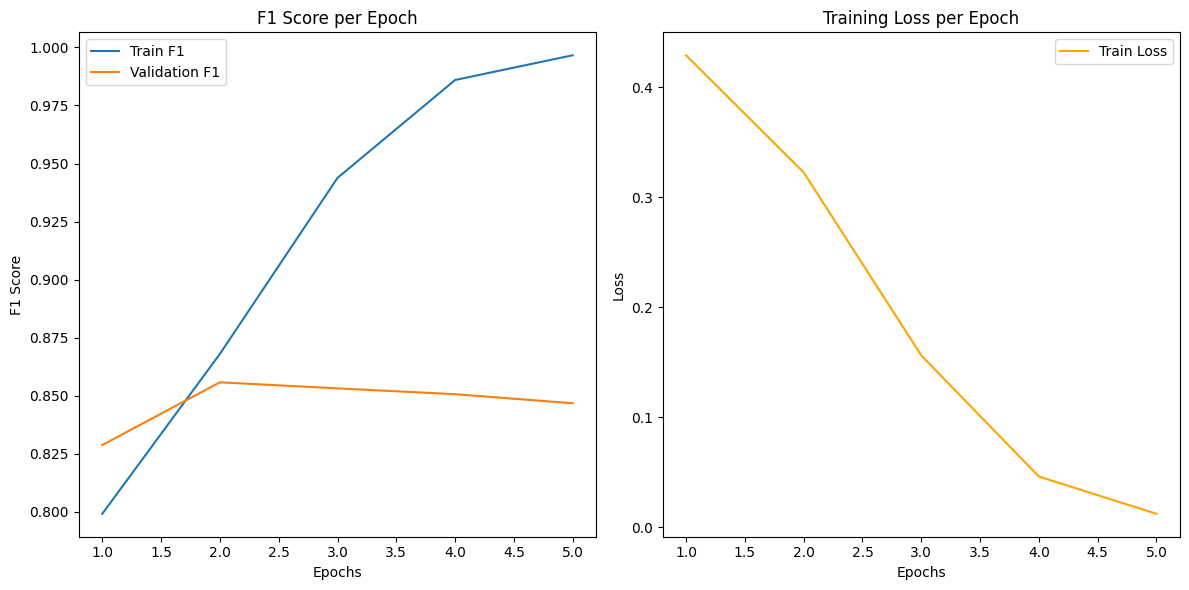

In [13]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

train_loss = []
train_f1_scores = []
val_f1_scores = []

scaler = GradScaler()
metric = evaluate.load('glue', 'mrpc') # Needed for evaluation

# Training loop with a progress bar
progress_bar = tqdm(range(num_training_steps))
model.train()

try:
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}")
        epoch_loss = 0
        train_preds = []
        train_labels = []

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()
            progress_bar.update(1)

            epoch_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            train_preds.extend(predictions.cpu().numpy())
            train_labels.extend(batch['labels'].cpu().numpy())

            if step % 50 == 0:
                print(f"Epoch {epoch + 1} | Step {step} | Loss: {loss.item()}")

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        train_loss.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1} | Average loss: {avg_epoch_loss:.4f}")

        # Calculate train F1 score
        train_f1 = metric.compute(predictions=train_preds, references=train_labels)['f1']
        train_f1_scores.append(train_f1)

        # Evaluation
        model.eval()
        val_preds = []
        val_labels = []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_preds.extend(predictions.cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())

        val_f1 = metric.compute(predictions=val_preds, references=val_labels)['f1']
        val_f1_scores.append(val_f1)
        model.train()

        print(f"Epoch {epoch + 1} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

except Exception as e:
    print(f"An error occurred: {e}")

# Plotting the F1 scores
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Plot F1 scores
plt.subplot(1, 2, 1)
plt.plot(epochs, train_f1_scores, label='Train F1')
plt.plot(epochs, val_f1_scores, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.show()
